In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  
from helper_function_obtain_data import *
import sys
import seaborn as sns
from scipy.interpolate import CubicSpline
import csv
import CCM
import sklearn
import scipy
plt.rcParams['figure.figsize'] = [12, 12]

(50,)


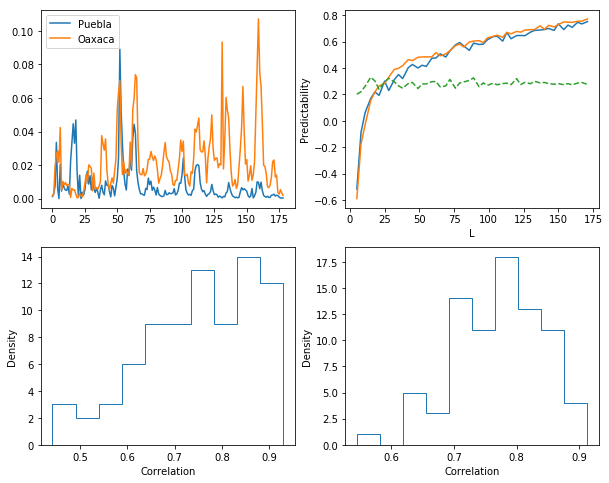

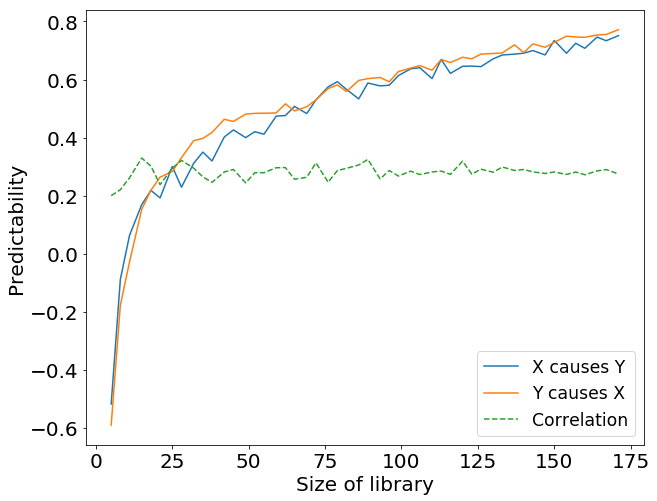

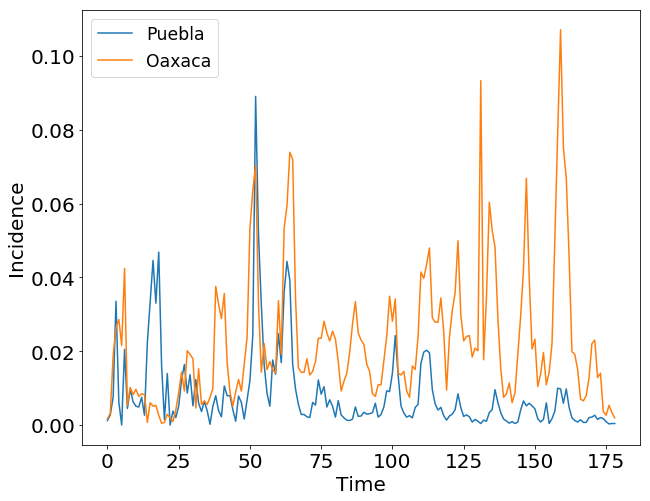

In [2]:
def ccm_two_states(stateA, stateB, tau):
    ## Obtain data
    disease = 'rubella'
    t, locations, tot_data, data_dic = preprocess_Mexico_disease_data(disease)
    x = data_dic[stateA] # causal variable, to be constructed
    y = data_dic[stateB] # use y to construct x
    start_year = 1986
    start_year_num = start_year - 1985 - 1
    start_month = 1
    start_time_ind = start_year_num*12 + start_month - 1
    end_year = 2000
    end_year_num = end_year - 1985 - 1
    end_month = 12
    end_time_ind = end_year_num*12 + end_month - 1
    t = t[start_time_ind:end_time_ind:1]
    x = x[start_time_ind:end_time_ind:1]/9815795*10**3 # chop the series at month/year
    y = y[start_time_ind:end_time_ind:1]/4126101*10**3 # chop the series at month/year
    
    # interpolate data using cubic spline
    dt = 1 # finer time step size
    t_finer = np.arange(0, len(x), dt) # finer time array
    cs = CubicSpline(t, x)
    X = cs(t_finer)
    cs = CubicSpline(t, y)
    Y = cs(t_finer)
    
    # generate embedding using the 1D time series
    eX = CCM.Embed(X) 
    eY = CCM.Embed(Y)
    E = 3 # embedding dimension
    Mx = eX.embed_vectors(tau,E) # shadow manifold of x
    My = eY.embed_vectors(tau,E) # shadow manifold of y
    # define the mapping
    convCrossMap = CCM.ccm(E,tau,X,Y)
    Lmin = 5 # minimum size of library in the rows of Mx or My
    Lmax = len(X) - (E-1)*tau # maximum size
    lib_lens = np.linspace(Lmin, Lmax, dtype='int') # generate array for L, the size of the library, used for convergence test
    print(lib_lens.shape)
    rho_X = np.zeros((len(lib_lens),1))
    rho_Y = np.zeros((len(lib_lens),1))
    
    p_value_X = np.zeros((len(lib_lens),1))
    p_value_Y = np.zeros((len(lib_lens),1))
    
    rho_orig = np.zeros((len(lib_lens),1)) # for storing the original Pearson correlation
    p_orig = np.zeros(rho_orig.shape)
    # start the convergence test
    for l in range(len(lib_lens)):
        L = lib_lens[l]
        
        # set up how many times to sample L many samples
        num_ensemble = 80#int(Lmax/L)
        
        rho_X_ens = np.zeros((num_ensemble,1))
        rho_Y_ens = np.zeros(rho_X_ens.shape)
        p_X_ens = np.zeros((num_ensemble,1))
        p_Y_ens = np.zeros(p_X_ens.shape)
        
        rho_orig_ens = np.zeros((num_ensemble,1))
        p_orig_ens = np.zeros(rho_orig_ens.shape)
        for i in range(num_ensemble):
            convCrossMap.sampling_without_replacement(Mx, My, L)
            y_Mx, x_My, x_orig, y_orig = convCrossMap.analysis(L)
            rho_X_ens[i], p_X_ens[i] = scipy.stats.pearsonr(x_My, x_orig)
            rho_Y_ens[i], p_Y_ens[i] = scipy.stats.pearsonr(y_Mx, y_orig)
            rho_orig_ens[i], p_orig_ens[i] = scipy.stats.pearsonr(x_orig, y_orig)
        if l == 0:
            rho_X_ens0 = rho_X_ens
            rho_Y_ens0 = rho_Y_ens

        rho_X[l] = np.mean(rho_X_ens)
        rho_Y[l] = np.mean(rho_Y_ens)
        
        p_value_X[l] = np.mean(p_X_ens)
        p_value_Y[l] = np.mean(p_Y_ens)
        
        # compute the Pearson correlation of the original two time series
        rho_orig[l] = np.mean(rho_orig_ens)
        
    # plotting
    plt.rcParams['figure.figsize'] = [10, 8]
    plt.figure(0)
    plt.subplot(2,2,1)
    plt.plot(t,x,label=stateA)
    plt.plot(t,y,label=stateB)
    plt.legend(loc='upper left')
    
    plt.subplot(2,2,2)
    plt.plot(lib_lens, rho_X, lib_lens, rho_Y)
    plt.plot(lib_lens,rho_orig, '--')
    plt.xlabel('L')
    plt.ylabel('Predictability')
    
    plt.subplot(2,2,3)
    plt.hist(rho_X_ens, bins = 10, histtype='step')
#     plt.hist(rho_X_ens0, bins = 10, histtype='step')
    plt.xlabel('Correlation')
    plt.ylabel('Density')
    
    plt.subplot(2,2,4)
    plt.hist(rho_Y_ens, bins = 10, histtype='step')
#     plt.hist(rho_Y_ens0, bins = 10, histtype='step')
    plt.xlabel('Correlation')
    plt.ylabel('Density')
    
    
    plt.figure(1)
    plt.plot(lib_lens, rho_X, label='X causes Y')
    plt.plot(lib_lens, rho_Y, label='Y causes X')
    plt.plot(lib_lens,rho_orig, '--',label='Correlation')
    plt.legend(loc=4, fontsize = 'xx-large')
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.xlabel('Size of library',fontsize = 20)
    plt.ylabel('Predictability',fontsize = 20)  
    plt.savefig("ccmresults.pdf", bbox_inches="tight")
    
    plt.figure(2)
    plt.plot(t,x,label=stateA)
    plt.plot(t,y,label=stateB)
    plt.legend(loc='upper left', fontsize = 'xx-large')
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.xlabel('Time',fontsize = 20)
    plt.ylabel('Incidence',fontsize = 20)  
    plt.savefig("PueblaVSOaxaca.pdf", bbox_inches="tight")
    return t_finer, y_Mx, x_My, x_orig, y_orig

stateA = 'Puebla'
stateB = 'Oaxaca'
tau = 4
t_finer, y_Mx, x_My, x_orig, y_orig = ccm_two_states(stateA, stateB, tau)



4


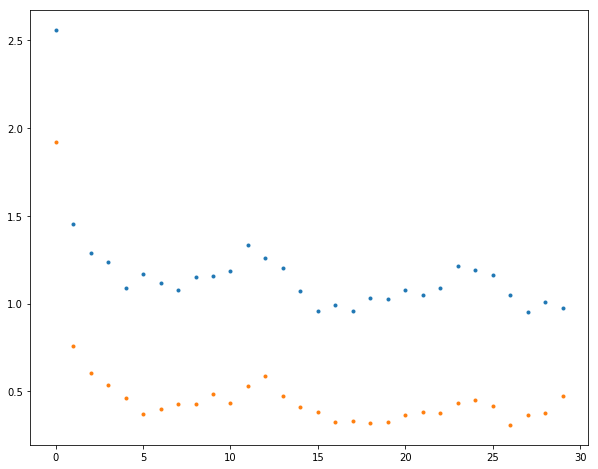

In [3]:
def compute_mutual_info(stateA, stateB, tau):
    ## compute mutual information between x(t) and x(t+tau)
    ## Obtain data
    disease = 'rubella'
    t, locations, tot_data, data_dic = preprocess_Mexico_disease_data(disease)
    x = data_dic[stateA]/9815795*10**3 # causal variable, to be constructed
    y = data_dic[stateB]/4126101*10**3 # use y to construct x
    
    # interpolate data using cubic spline
    dt = 1 # finer time step size, 1 is a month
    t_finer = np.arange(0, len(x), dt) # finer time array
    cs = CubicSpline(t, x)
    X_orig = cs(t_finer)
    cs = CubicSpline(t, y)
    Y_orig = cs(t_finer)
    
    start_year = 1988
    start_year_num = start_year - 1985 - 1
    start_month = 1
    start_time_ind = start_year_num*12 + start_month - 1
    end_year = 1997
    end_year_num = end_year - 1985 - 1
    end_month = 12
    end_time_ind = end_year_num*12 + end_month - 1
    
    X = X_orig[start_time_ind*int(1/dt):end_time_ind*int(1/dt):1]
    X_tau = X_orig[start_time_ind*int(1/dt)+tau:end_time_ind*int(1/dt)+tau:1]
    Y = Y_orig[start_time_ind*int(1/dt):end_time_ind*int(1/dt):1]
    Y_tau = Y_orig[start_time_ind*int(1/dt)+tau:end_time_ind*int(1/dt)+tau:1]
    
    # compute mutual information
    bins = 31
    c_x = np.histogram2d(X, X_tau, bins)[0]
    mi_x = sklearn.metrics.mutual_info_score(None, None, contingency=c_x)
    c_y = np.histogram2d(Y, Y_tau, bins)[0]
    mi_y = sklearn.metrics.mutual_info_score(None, None, contingency=c_y)
    return mi_x, mi_y

stateA = 'Mexico'
stateB = 'Puebla'
tau_vec = np.arange(0,30,1)
mi_x = np.zeros((len(tau_vec),1))
mi_y = np.zeros((len(tau_vec),1))

for ind in range(len(tau_vec)):
    mi_x[ind], mi_y[ind] = compute_mutual_info(stateA, stateB, tau_vec[ind])



plt.plot(tau_vec,mi_x, '.', tau_vec,mi_y,'.')
print(tau_vec[4])

In [6]:
def extended_ccm_two_states(stateA, stateB, taux, tauy, Ex, Ey, Lag, dt):
    """
    Computes effect lags
    INPUT:
    stateA - string
    stateB - string
    tau - time 
    dt - float number, finer time step size, 1 is a month
    """
    ## Obtain data
    disease = 'rubella'
    t, locations, tot_data, data_dic = preprocess_Mexico_disease_data(disease)
    
    x = data_dic[stateA] # state A disease population
    y = data_dic[stateB] # state B disease population
    
    # interpolate data using cubic spline
    t_finer = np.arange(0, len(x), dt) # finer time array
    cs = CubicSpline(t, x)
    X_orig = cs(t_finer)
    cs = CubicSpline(t, y)
    Y_orig = cs(t_finer)
    
    start_year = 1988
    start_year_num = start_year - 1985 - 1
    start_month = 1
    start_time_ind = start_year_num*12 + start_month - 1
    end_year = 1996
    end_year_num = end_year - 1985 - 1
    end_month = 12
    end_time_ind = end_year_num*12 + end_month - 1
    
    # allocate memory
    rho_X = np.zeros((len(Lag),1))
    rho_Y = np.zeros((len(Lag),1))
    
    std_X = np.zeros((len(Lag),1))
    std_Y = np.zeros((len(Lag),1))
    
    p_value_X = np.zeros((len(Lag),1))
    p_value_Y = np.zeros((len(Lag),1))
    
    
    ## start the loop in Lag to calculate y|Mx(t-l)
    ## assumption is that y is the driving variable
    for lag_ind in range(len(Lag)):     
        lag = Lag[lag_ind]
        
        X = X_orig[start_time_ind*int(1/dt)-lag:end_time_ind*int(1/dt)-lag:1]
        Y = Y_orig[start_time_ind*int(1/dt):end_time_ind*int(1/dt):1]
        # generate embedding using the 1D time series
        eX = CCM.Embed(X) 
        eY = CCM.Embed(Y)
        Mx = eX.embed_vectors(tauy,Ey) # shadow manifold of x
        My = eY.embed_vectors(tauy,Ey) # shadow manifold of y
        # define the mapping
        convCrossMap = CCM.ccm(Ey,tauy,X,Y)
        L = len(X) - (Ey-1)*tauy # library size
        
        # set up how many times to sample L many samples
        num_ensemble = 100#int(Lmax/L)
        
        rho_Y_ens = np.zeros((num_ensemble,1))
        p_Y_ens = np.zeros((num_ensemble,1))
        
        for i in range(num_ensemble):
            convCrossMap.sampling_without_replacement(Mx, My, L)
            y_Mx, x_My, x_ordered, y_ordered = convCrossMap.analysis(L)
            rho_Y_ens[i], p_Y_ens[i] = scipy.stats.pearsonr(y_Mx, y_ordered)
        
        # compute statistics of the ensemble
        rho_Y[lag_ind] = np.mean(rho_Y_ens)
        std_Y[lag_ind] = np.std(rho_Y_ens)
        p_value_Y[lag_ind] = np.mean(p_Y_ens)
        
        
    ## start the loop in Lag to calculate x|My(t-l)
    ## assumption is that x is the driving variable
    for lag_ind in range(len(Lag)):     
        lag = Lag[lag_ind]
        
        X = X_orig[start_time_ind*int(1/dt):end_time_ind*int(1/dt):1]
        Y = Y_orig[start_time_ind*int(1/dt)-lag:end_time_ind*int(1/dt)-lag:1]
        # generate embedding using the 1D time series
        eX = CCM.Embed(X) 
        eY = CCM.Embed(Y)
        Mx = eX.embed_vectors(taux,Ex) # shadow manifold of x
        My = eY.embed_vectors(taux,Ex) # shadow manifold of y
        # define the mapping
        convCrossMap = CCM.ccm(Ex,taux,X,Y)
        L = len(X) - (Ex-1)*taux # library size
        
        # set up how many times to sample L many samples
        num_ensemble = 100#int(Lmax/L)
        
        rho_X_ens = np.zeros((num_ensemble,1))
        p_X_ens = np.zeros((num_ensemble,1))
        
        for i in range(num_ensemble):
            convCrossMap.sampling_without_replacement(Mx, My, L)
            y_Mx, x_My, x_ordered, y_ordered = convCrossMap.analysis(L)
            rho_X_ens[i], p_X_ens[i] = scipy.stats.pearsonr(x_My, x_ordered)

        # compute statistics of the ensemble
        rho_X[lag_ind] = np.mean(rho_X_ens)
        std_X[lag_ind] = np.std(rho_X_ens)
        p_value_X[lag_ind] = np.mean(p_X_ens)
    
    
    
    # plotting
    plt.rcParams['figure.figsize'] = [10, 8]
    plt.subplot(1,2,1)
    plt.plot(t,x,label=stateA)
    plt.plot(t,y,label=stateB)
    plt.legend(loc='upper left')
    
    plt.subplot(1,2,2)
    Lag_unit = Lag*dt # has unit in month
    plt.plot(Lag_unit, rho_X, label=stateA+' drives '+stateB) 
    plt.plot(Lag_unit, rho_Y, label=stateB+' drives '+stateB)
    plt.legend(loc='upper right')
    plt.xlabel('Lag in month')
    plt.ylabel('Correlation')
    
    return 
    
    


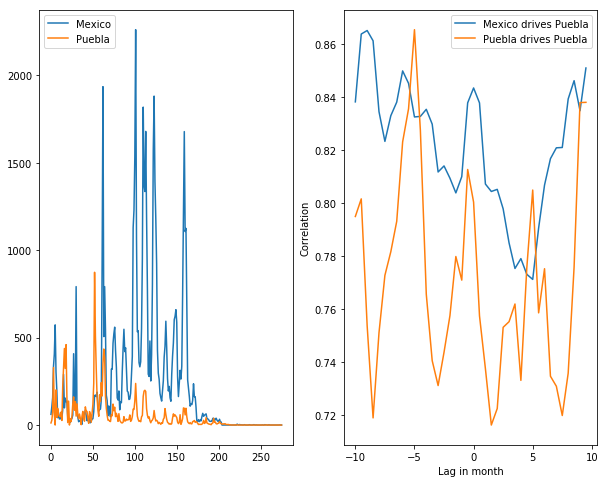

In [7]:
# test
stateA = 'Mexico'
stateB = 'Puebla'
# optimal time delay
taux = 3
tauy = 7
# optimal embedded dimension
Ex = 3
Ey = 2
Lag = np.arange(-20,20,1) # possible lags to choose
dt = 0.5
extended_ccm_two_states(stateA, stateB, taux, tauy, Ex, Ey, Lag, dt)